In [1]:
import sys
import numpy as np
import math
import ceo
import matplotlib.pyplot as plt
import IPython
%matplotlib inline

pupil sampling:      469 pixel
SH Pixel scale: 0.132arcsec
SH Field of view: 2.376arcsec


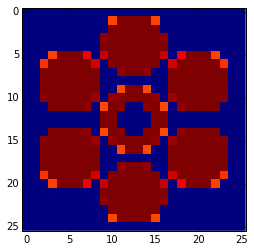

In [2]:
# Telescope parameters
D = 26.
nPx = 469
radial_order = 4
n_zern = (radial_order+1)*(radial_order+2)/2
gmt = ceo.GMT_MX(D,nPx,M1_radial_order=radial_order,M2_radial_order=radial_order)

# Off-axis GSs for field residuals evaluations
alpha_off = np.arange(0., 60.*11., 120.)  #  [in arcsec]
N_OFF = alpha_off.size
zenith_angle_off  = alpha_off*math.pi/180/3600 # in radians
azimuth_angle_off = np.zeros(N_OFF)       # in degrees

offgs = ceo.Source("R",zenith=zenith_angle_off,azimuth=azimuth_angle_off*math.pi/180,
                    rays_box_size=D,rays_box_sampling=nPx,rays_origin=[0.0,0.0,25])

# on-axis GS for wavefront sensing
ongs = ceo.Source("R",zenith=0.,azimuth=0., rays_box_size=D,rays_box_sampling=nPx,rays_origin=[0.0,0.0,25])

# on-axis SH WFS parameters
nLenslet = 26  # number of sub-apertures across the pupil
n = 18         # number of pixels per subaperture
detectorRes = 2*n*nLenslet/2
BINNING = 2
wfs = ceo.ShackHartmann(nLenslet, n, D/nLenslet,N_PX_IMAGE=2*n,BIN_IMAGE=BINNING,N_GS=1)

# Calibrate WFS slope null vector
ongs.reset()
gmt.reset()   # Telescope perfectly phased
gmt.propagate(ongs)
wfs.calibrate(ongs,0.8)
plt.imshow(wfs.flux.host(shape=(nLenslet,nLenslet)),interpolation='none')

print "pupil sampling:      %d pixel"%nPx
print "SH Pixel scale: %.3farcsec"%(wfs.pixel_scale_arcsec)
sh_fov = wfs.pixel_scale_arcsec*wfs.N_PX_IMAGE/BINNING
print "SH Field of view: %.3farcsec"%(sh_fov)

<matplotlib.colorbar.Colorbar instance at 0x2b0bee106f80>

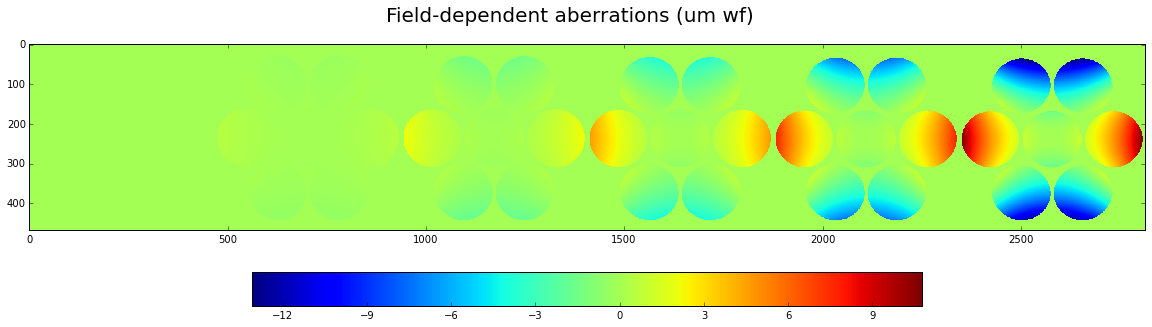

In [3]:
#Get residual WF solely due to telescope aberrations when perfectly aligned
offgs.reset()
gmt.reset()
gmt.propagate(offgs)
Wref = np.rollaxis( offgs.wavefront.phase.host(units='nm', shape=(1,offgs.N_SRC,offgs.n*offgs.m)),1,3)

ph_fda = offgs.phase.host(units='micron').T
fig, ax = plt.subplots()
fig.set_size_inches(20,5)
fig.suptitle('Field-dependent aberrations (um wf)', fontsize=20)
imm = ax.imshow(ph_fda, interpolation='None')
fig.colorbar(imm, orientation='horizontal', shrink=0.6)

___ M2 ___
Segment #0: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Segment #1: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Segment #2: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Segment #3: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Segment #4: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Segment #5: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Segment #6: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
------------
(624, 98)


<matplotlib.colorbar.Colorbar instance at 0x2b0bedd11638>

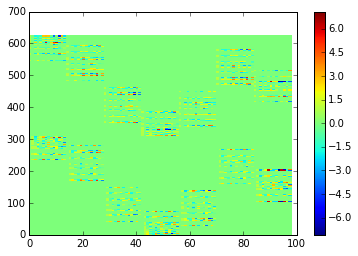

In [4]:
# Calibrate M2 segment Zernikes Interaction Matrix with on-axis WFS
# NOTE:  GMTILB.PY  modified to include TT in Zernikes !!!!

Zstroke = 50e-9 #m rms
D_M2_Z = gmt.calibrate(wfs, ongs, mirror="M2", mode="zernike", stroke=Zstroke)
print D_M2_Z.shape
nzernall = (D_M2_Z.shape)[1]  ## number of zernike DoFs calibrated

plt.pcolor(D_M2_Z)
plt.colorbar()

In [5]:
R_M2_Z = np.linalg.pinv(D_M2_Z)
print R_M2_Z.shape
print np.linalg.cond(D_M2_Z)

(98, 624)
5.97813441092


In [41]:
# Calibrate M2 segment TT Interaction Matrix and Reconstructor
TTstroke = 25e-3 #arcsec
gmt.reset()
D_M2_TT = gmt.calibrate(wfs, ongs, mirror="M2", mode="segment tip-tilt", stroke=TTstroke*math.pi/180/3600)
R_M2_TT = np.linalg.pinv(D_M2_TT)
R_M2_TT.shape

___ M2 ___
Segment #:1 2 3 4 5 6 7 
------------


(14, 624)

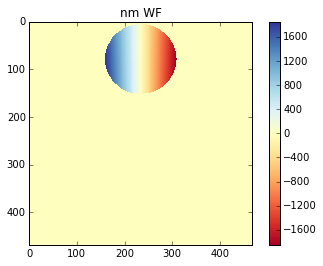

In [46]:
# Apply a Zernike vector to a particular segment on M1
segId = 4
aidx = np.arange(0,n_zern)
a_M1 = np.zeros(n_zern)   #zernike coeffs, from piston Z1 to n_zern
a_M1[1] = 500e-9      # m RMS surf

ongs.reset()
gmt.reset()
gmt.M1.zernike.a[segId-1,:] = a_M1
gmt.M1.zernike.update()
gmt.propagate(ongs)

plt.imshow(ongs.phase.host(units='nm'),interpolation='None',cmap='RdYlBu')
plt.colorbar()
plt.title("nm WF")

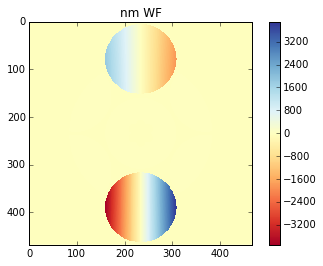

In [47]:
# Apply a known Tilt to a particular segment on M1
segId = 1
myTTvalue = 100e-3 #arcsec
M1TTvec = np.array([0, myTTvalue, 0])*math.pi/180/3600

ongs.reset()
#gmt.reset()
gmt.M1.update(euler_angles=M1TTvec, idx=segId)
gmt.propagate(ongs)

plt.imshow(ongs.phase.host(units='nm'),interpolation='None',cmap='RdYlBu')
plt.colorbar()
plt.title("nm WF")

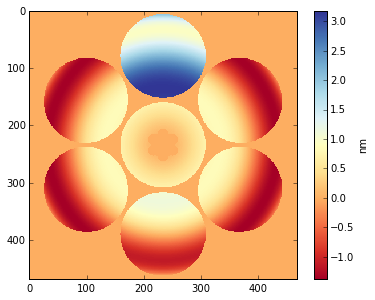

In [48]:
# Close the loop with the on-axis WFS commanding M2
f, ax = plt.subplots()
f.set_size_inches(6,8)
USE_TT_REC = 'False' #If True use TT rec, otherwise use Zern rec

niter = 5
rmsval = np.zeros(niter)
a_M2 = np.zeros(nzernall)
myTTest1 = np.zeros(14)
for ii in range(5):
    ongs.reset()
    gmt.propagate(ongs)
    rmsval[ii] = ongs.wavefront.rms()
    wfs.reset()
    wfs.analyze(ongs)
    slopevec = wfs.valid_slopes.host().ravel()
    #---- compensation with zernike modes
    if USE_TT_REC == 'False':
        a_M2 += np.dot(R_M2_Z, slopevec) 
        atemp = a_M2.reshape((7,-1))
        gmt.M2.zernike.a[:,1:] = -atemp
        gmt.M2.zernike.update()
    #---- compensation with TT only
    else:
        myTTest1 += np.dot(R_M2_TT, slopevec)
        myTTest = myTTest1.reshape((7,2))
        for idx in range(7): gmt.M2.update(euler_angles=np.array([-myTTest[idx,0],-myTTest[idx,1],0]), idx=idx+1)
    #---- visualization
    if ii > 0: clb.remove()
    h = ax.imshow(ongs.phase.host(units='nm'),interpolation='None',cmap='RdYlBu')
    clb = f.colorbar(h, ax=ax, shrink=0.6)
    clb.set_label('nm')
    IPython.display.clear_output(wait=True)
    IPython.display.display(f)

plt.close()

[ 825.10518951   34.37590834    1.09586851    1.09600173    1.0959611 ]


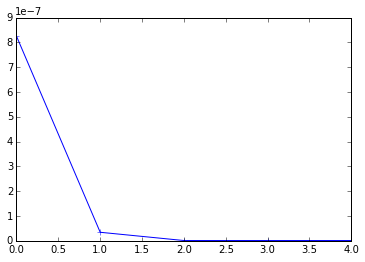

In [49]:
plt.plot(rmsval, '-+')
print rmsval*1e9